# Word Meaning
Do the meanings of words used in the political discourse change over time, can we quantify this?

In [1]:
import pandas as pd
import os
import sys
import json
import re
import random
import matplotlib.pyplot as plt
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from collections import Counter, defaultdict
from nltk.stem import PorterStemmer
from fuzzysearch import find_near_matches
import swifter 
from tqdm import tqdm
tqdm.pandas()
import datetime
from scipy.ndimage.filters import gaussian_filter1d

from wordcloud import WordCloud

stop_words = set(stopwords.words('english')) 
stop_words = stop_words.union(set(['ladies', 'gentlemen']))

In [2]:
# Add repo
git_dir = os.path.abspath('../')
sys.path.append(os.path.join(git_dir, 'lib', 'utils') )

# Define data output path
transcript_path = os.path.join(git_dir, 'data', 'pm-transcripts-processed/aggregated-spellfixed-typed.csv')

fig_dir = os.path.join(git_dir, 'figs')

#Read in, make string lists into strings
df_raw = pd.read_csv(transcript_path)
df_raw['sentences'] = df_raw['sentences'].map(eval)
df_raw['date'] = pd.to_datetime(df_raw['date'])
df_raw = df_raw[df_raw['date'] > datetime.datetime(year=1980, month=1, day=1)]

In [3]:
# All other types dont have enough structure.
release_types = ['Media Releases', 'Speech']
df = df_raw[df_raw['type'].isin(release_types)].drop('Unnamed: 0', axis=1)
df['year'] = pd.DatetimeIndex(df['date']).year

In [4]:
# Baseline language data
flat_corpus = ' '.join(df.sentences.sum())
token_corpus = word_tokenize(flat_corpus)
token_corpus_filtered = [w for w in token_corpus if not w in stop_words]
corpus_freqs = Counter(token_corpus_filtered)
most_common = corpus_freqs.most_common(300)
corpus_norm = len(token_corpus_filtered)

In [5]:
woi = {
    'ind': ['aboriginal', 'first nations', 'aborigine', 'indigenous', 'torres strait island'],
    'econ': ['economy', 'economic'],
    'aus': ['australia', 'australian', 'aussie', 'australians'],
    'gov': ['government'],
    'ref': ['immigrant', 'asylum seeker', 'boat people', 'illegal arrivals', 'boat arrivals', 'boat'],
    'env': ['fire', 'bushfire', 'climate change', 'climate action', 'extinction', 'global warming', 'greenhouse', 'emissions', 'environment', 'coral reef', 'reef', 'climate', 'degradation', 'sustainability']
}
filters = {
    'ind': [
           'aboriginal', 
           'first nations', 
           'aborigine', 
           'indigenous', 
           'torres', 
           'strait', 
           'island',
           'australia', 
           'australian', 
           'aussie',
           'australians',
           'government',
           'nation',
           'year',
           'country'
          ],
    'econ': [
        'economy', 
        'economic',
        'australia', 
        'australian', 
        'aussie',
        'australians',
        'government',
        'nation',
        'year',
        'country'
    ],
    'gov': [
        'australia', 
        'australian', 
        'aussie',
        'australians',
        'government',
        'nation',
        'year',
        'country' 
    ],
    'gen': [
        'australia', 
        'australian', 
        'aussie',
        'australians',
        'government',
        'nation',
        'year',
        'country' 
    ],
    'ref': [
        'aboriginal', 
        'first nations', 
        'aborigine', 
        'indigenous', 
        'torres', 
        'strait', 
        'island',
        'australia', 
        'australian', 
        'aussie',
        'australians',
        'government',
        'nation',
        'year',
        'country' 
    ]
}

In [6]:
def find_colocation_neighbours(idxs_in, size, dist = 1):
    idxs = idxs_in.copy()
    for idx in idxs:
        for d in range(dist):
            if not idx - d < 0:
                idxs_in.append(idx-d) 
            if not idx + d > size:
                idxs_in.append(idx+d)

def fuzzy_colocation(sequences, search_key, stemmer):
    ret = []
    for index, sequence in enumerate(sequences):
        if any([len(find_near_matches(subsequence, sequence, max_l_dist=2)) > 0 
             for subsequence in search_key]):
            ret.append(index)
    find_colocation_neighbours(ret, len(sequences))
    acc = ' '.join([sequences[indx] for indx in ret])
    return Counter([stemmer.stem(w) 
            for w in word_tokenize(acc) 
            if not w in stop_words])

In [7]:
def get_cooccurence(
    search_key,
    key,
    filters
):
    search_key = woi[key]
    df[f'{key}'] = df['sentences']\
        .progress_map(lambda x: fuzzy_colocation(x, search_key, PorterStemmer()))

    cooccur_number = df.groupby('year')[key].sum()
    total_freqs = cooccur_number.sum()

    timeseries = defaultdict(list)
    stemmer = PorterStemmer()
    stemmed_filter = [stemmer.stem(x) for x in filters]

    timeseries = defaultdict(list)
    for x in total_freqs:
        if x not in stemmed_filter:
            for counter in cooccur_number.to_list():
                timeseries[x].append(counter.get(x, 0))

    totals = {}
    for w in timeseries:
        totals[w] = sum(timeseries[w])

    most_common = list(dict(Counter(totals).most_common(20)).keys())

    return cooccur_number, most_common, timeseries

In [8]:
def plot_coccurence(
    key,
    cooccur_number,
    most_common,
    timeseries,
    group,
    context
):
    for x in most_common[group[0]:group[1]]:
        plt.plot(cooccur_number.index, gaussian_filter1d(timeseries[x], sigma=2))
        plt.legend(most_common[group[0]:group[1]])
#     plt.title(f'Language Addressing {context} Issues')
    plt.savefig(f'{fig_dir}/{group[0]}-{group[1]}-{key}.png')
    plt.show()

In [9]:
def generate_and_plot(
    search_key,
    key,
    filters,
    context
):
    cooccur_number, most_common, timeseries = get_cooccurence(search_key,key,filters)
    plot_coccurence(
        key,
        cooccur_number,
        most_common,
        timeseries,
        (0,5),
        context
    )
    plot_coccurence(
        key,
        cooccur_number,
        most_common,
        timeseries,
        (5,10),
        context
    )
    plot_coccurence(
        key,
        cooccur_number,
        most_common,
        timeseries,
        (10,15),
        context
    )
    plot_coccurence(
        key,
        cooccur_number,
        most_common,
        timeseries,
        (15,20),
        context
    )

In [22]:
key = 'aus'
generate_and_plot(woi[key], key, filters['ind'], 'First Nations')

100%|██████████| 3837/3837 [03:09<00:00, 20.25it/s]


KeyError: 'year'

In [ ]:
key = 'econ'
generate_and_plot(woi[key], key, filters['econ'], 'Economics')

In [ ]:
key = 'ref'
generate_and_plot(woi[key], key, filters['ref'], 'Refugee')

100%|██████████| 3837/3837 [08:36<00:00,  7.43it/s]


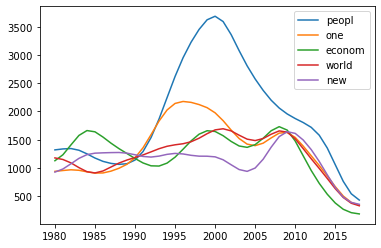

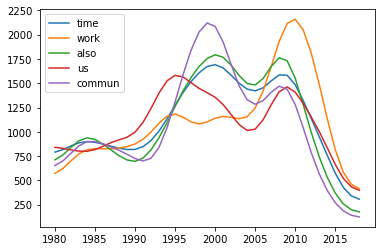

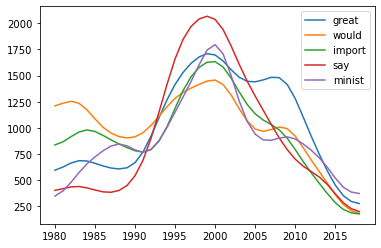

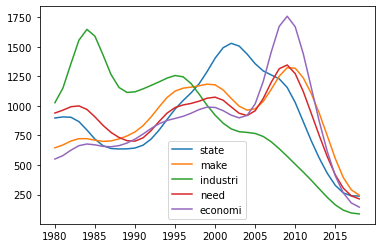

In [10]:
key = 'env'
generate_and_plot(woi[key], key, filters['gen'], 'Environment')